# To do's:
* Laura move example here and delete previous files
* Siren adjust release locations
* Siren: fancy cumulative dist
* laura simple total and cum dist
* dt = 25 mins --> check

30 days

In [1]:
import matplotlib.pyplot as plt 

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter#
import matplotlib.ticker as mticker


In [2]:
import xarray as xr

In [3]:
ds_m = xr.open_dataset('/storage/shared/oceanparcels/input_data/CMEMS/GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/SMOC_20210109_R20210110.nc')

In [4]:
ds_m

<xarray.Dataset>
Dimensions:    (longitude: 4320, latitude: 2041, depth: 1, time: 24)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth      (depth) float32 0.494
  * time       (time) datetime64[ns] 2021-01-09T00:30:00 ... 2021-01-09T23:30:00
Data variables:
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    vsdx       (time, depth, latitude, longitude) float32 ...
    vsdy       (time, depth, latitude, longitude) float32 ...
    utide      (time, depth, latitude, longitude) float32 ...
    vtide      (time, depth, latitude, longitude) float32 ...
    utotal     (time, depth, latitude, longitude) float32 ...
    vtotal     (time, depth, latitude, longitude) float32 ...
Attributes: (12/19)
    product:                       GLOBAL_ANALYSIS_FORECAST_PHY_001_024
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    title:                         hourly mean merged surface currents from o...
    area:                          GLOBAL
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    ...                            ...
    institution:                   MERCATOR OCEAN
    julian_day_unit:               hours since 1950-01-01 00:00:00
    latitude_min:                  -80
    latitude_max:                  90.0
    longitude_min:                 -180.0
    longitude_max:                 179.91667175293

In [5]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter

In [6]:
# Lorenz directory
filedir = '/storage/shared/oceanparcels/input_data/CMEMS/'


In [7]:
filenames = {'U': filedir + "GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/SMOC_20210[1-2]*",
             'V': filedir + "GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/SMOC_20210[1-2]*"}

## we use the eulerian velocity (uo and vo):

In [8]:
variables = {'U': 'uo',
             'V': 'vo'}
dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

In [9]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

# Releasing 1 particle per fieldset grid point


In [10]:
lon1D = fieldset.U.lon[np.arange(2430,2490,5)]
lat1D = fieldset.U.lat[np.arange(490,550,5)]

lons, lats = np.meshgrid(lon1D, lat1D) 
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)



In [11]:
def DeleteParticle(particle, fieldset, time):
    particle.delete

In [12]:
output_file = pset.ParticleFile(name="test_02.nc", outputdt=timedelta(hours=6))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=30),
             dt=timedelta(minutes=25),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=output_file)

sh: None: command not found
INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-319202/lib097558d25442a0b09d555fb4861a5b6d_0.so
INFO: Temporary output files are stored in out-VIPEAUMU.
INFO: You can use "parcels_convert_npydir_to_netcdf out-VIPEAUMU" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:07:15 Time:  0:07:15


In [13]:
output_file.export()


In [14]:
ds = xr.open_dataset('test_02.nc')

In [18]:
ds

<xarray.Dataset>
Dimensions:     (traj: 144, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical

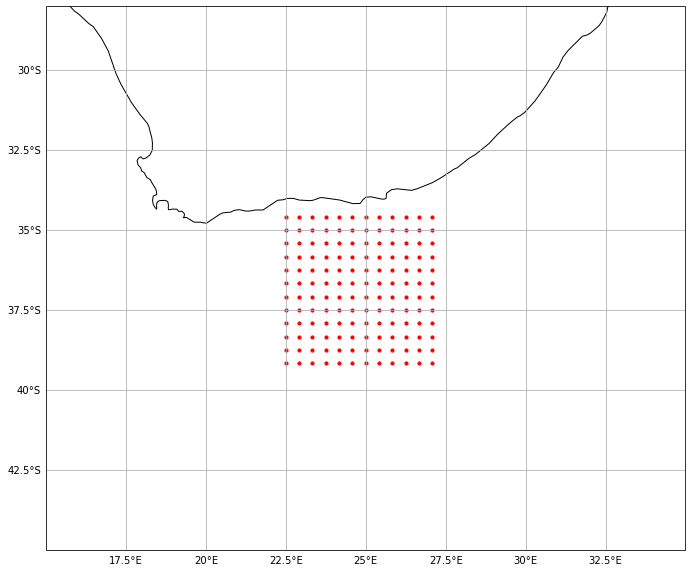

In [15]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([15, 35])
ax1.set_ylim([-45, -28])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


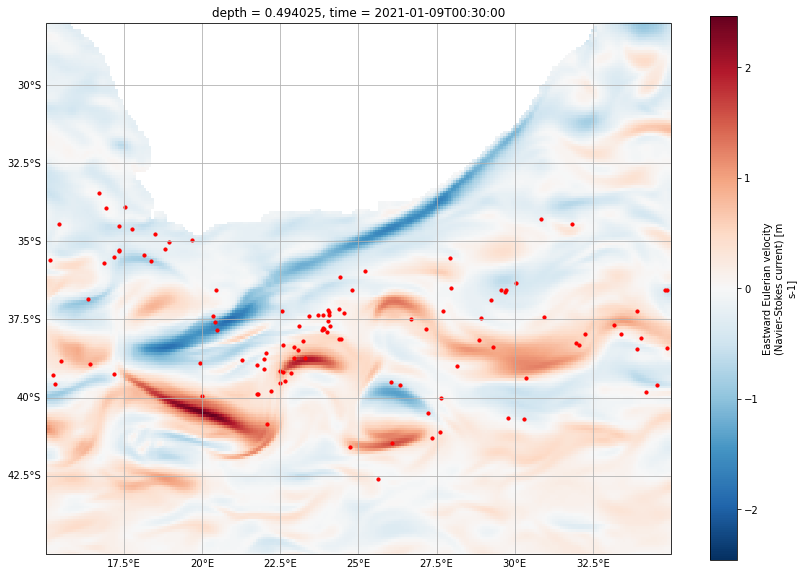

In [16]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ds_m.uo[0,0,:,:].plot()
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([15, 35])
ax1.set_ylim([-45, -28])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


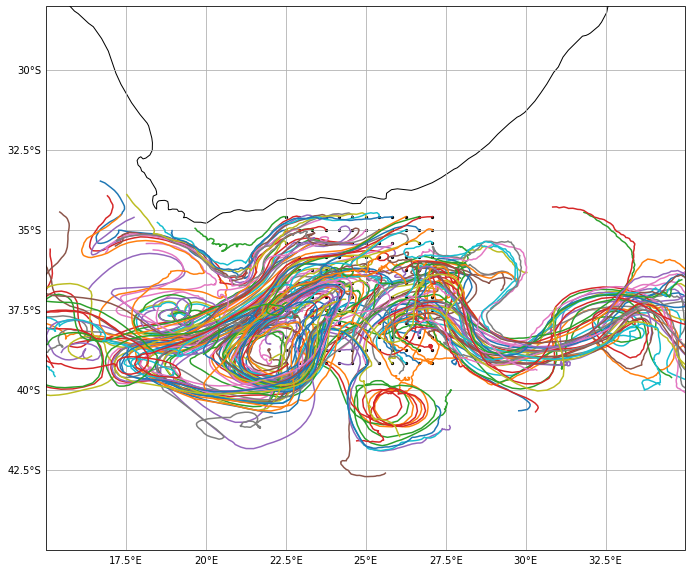

In [17]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([15, 35])
ax1.set_ylim([-45, -28])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)